In [16]:
import numpy as np 
from scipy.linalg import svdvals
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from tqdm.notebook import tqdm
from scipy.stats import spearmanr,kendalltau
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [18]:
def rl_svd(A_d, V, mode):
    """right(left) svd decomposition. Returns U_d(V_d) based on input original V(U)"""
    m, n = A_d.shape
    r_max = min(m, n) # max matrix rank

    if mode == 'right': # than V is actually V in SVD and we perform right svd
        U_d = A_d @ V[:, :r_max]
        U_d_n = np.zeros((m, m)) # preparation for normalized U_d
    elif mode == 'left': # than V is actually U in SVD and we perform left svd
        U_d = A_d.T @ V[:, :r_max]
        U_d_n = np.zeros((n, n)) # preparation for normalized U_d
    else:
        raise ValueError('Mode can be left or right')

    # get singular values and set them to zero if less then s_thr
    s = np.linalg.norm(U_d, axis=0)
    s_thr = 1e-12
    ind = (s >= s_thr)
    s[s < s_thr] = 0
    r = np.count_nonzero(s)

    U_d_n[:, ind] = U_d[:, ind] / s[ind]
    return U_d_n, s

In [19]:
def SSVD(A_d, u_t, s_t, v_t, w, cpf):
    ''' Factor of structural distortion
        A_d - distorted block
        CPF - CooPerative Factor (threshold of svd)
    '''
    # u_t, s_t, vh_t = np.linalg.svd(A_t)
    # v_t = vh_t.T
    # w = s_t / np.sum(s_t) + c

    # Sv
    u_d, s_d_u = rl_svd(A_d, v_t, mode='right')
    I_d_u = u_t @ u_d.T 
    S_v = svdvals(I_d_u)   

    # Su
    v_d, s_d_v = rl_svd(A_d, u_t, mode='left')
    I_d_v = v_t @ v_d.T 
    S_u = svdvals(I_d_v)

    # Fs
    Fsv = np.sqrt(np.sum(((S_v - 1) * w)[:cpf] ** 2 ))
    Fsu = np.sqrt(np.sum(((S_u - 1) * w)[:cpf] ** 2 ))

    Fs = (Fsv + Fsu) / 2

    # Fl
    Flv = np.sqrt(np.sum((abs(s_d_v - s_t) * w)[:cpf]))
    Flu = np.sqrt(np.sum((abs(s_d_u - s_t) * w)[:cpf]))
    Fl = (Flu + Flv) / 2

    # Fr
    S_d = svdvals(A_d)
    Qsv = np.sqrt(np.sum((S_d - s_d_v)[:cpf] ** 2))
    Qsu = np.sqrt(np.sum((S_d - s_d_u)[:cpf] ** 2))

    eps = 1e-2
    Qrh = 2 * Qsu * Qsv / (Qsu + Qsv + eps)

    h = 4 * A_t.shape[0]
    Fr = 1 - np.exp(-Qrh / h)

    return np.array([Fl, Fs, Fr])

In [20]:
def im2mat(path, height=306, width=306, block_size=9):
    '''PIL image to greyscale np.array with pads'''
    im = Image.open(path)
    im = ImageOps.grayscale(im)

    # Work with sizes
    im = im.resize((height, width)) # make it the same size
    im = np.array(im) # convert to array
    if height % block_size == 0:
        pad_height = 0
    else:
        pad_height = block_size - height % block_size
        

    if width % block_size == 0:
        pad_width = 0
    else:
        pad_width = block_size - width % block_size

    im = np.pad(im, ((0, pad_height),(0, pad_width))) # add padding

    return im
    
def mat2block(A, block_n, block_m):
    '''Crop matrix into blocks'''
    n, m = A.shape
    B = []
    for rect in np.array_split(A, n / block_n, axis=0):
        for block in np.array_split(rect, m / block_m, axis=1):
            B.append(block)
    return np.array(B)

In [94]:
block_size = 9
n, m = 306, 306

c = 0.01

n_im = 100
n_dist = 2

F, Fl, Fs, Fr = ([],[],[],[])


for i in tqdm(range(1, n_im + 1)): # over images

    # download target image
    im_path = 'datasets/100_selfies/' + "{0:0=5d}".format(i) + '.jpg'
    I_t = im2mat(im_path)

    # crop it into blocks
    I_t_bl = mat2block(I_t, block_size, block_size) # array of blocks

    # distorted images
    n_blocks = I_t_bl.shape[0]

    # same for distorted images correspondint the the ith target image
    I_d = []

    for d in range(1, n_dist + 1): # over distortion types
            im_path = 'datasets/100_selfies_re' + str(d) + '/' +  "{0:0=5d}".format(i) + '.jpg'
            i_d = im2mat(im_path)
            I_d.append(i_d)

    I_d_bl = np.array([mat2block(i_d, block_size, block_size) for i_d in I_d]).swapaxes(0,1) # array of block arrays

    # now run over blocks and compute corresponding F
    f = []
    for b in range(n_blocks):
        A_t = I_t_bl[b]

        u_t, s_t, vh_t = np.linalg.svd(A_t)
        v_t = vh_t.T
        w = s_t / np.sum(s_t) + c
        f_block = np.array([SSVD(A_d, u_t, s_t, v_t, w, 7) for A_d in I_d_bl[b]])
        f.append(f_block)
    f = np.array(f)
    
    F.append(np.mean(np.prod(f, axis=2), axis=0))
    Fl.append(np.mean(f[:, :, 0], axis=0))
    Fs.append(np.mean(f[:, :, 1], axis=0))
    Fr.append(np.mean(f[:, :, 2], axis=0))

F = np.array(F)
Fl = np.array(Fl)
Fs = np.array(Fs)
Fr = np.array(Fr)

  0%|          | 0/100 [00:00<?, ?it/s]

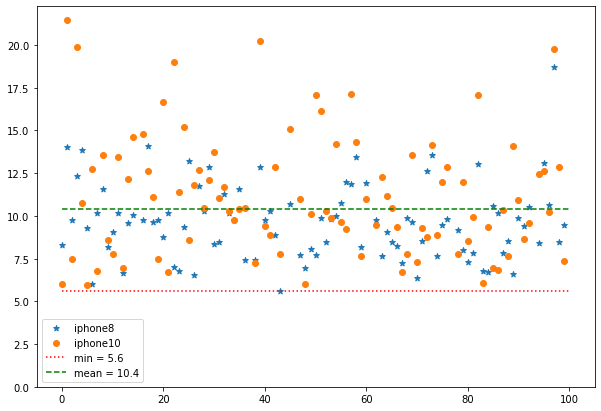

In [109]:
minimum = np.min(F[~np.isnan(F)])
mean = np.mean(F[~np.isnan(F)])

plt.figure(figsize = (10,7))
plt.scatter(np.arange(len(F)), F[:,0], label='iphone8', marker='*')
plt.scatter(np.arange(len(F)), F[:,1], label='iphone10', marker='o')
plt.hlines(minimum, 0, len(F), linestyles='dotted', color='r', label=f'min = {round(minimum, 1)}')
plt.hlines(mean, 0, len(F), linestyles='dashed', color='g', label=f'mean = {round(mean,1)}')
plt.legend()
plt.ylim(bottom=0);

In [116]:
# Save the results
np.save('results/F', F)
np.save('results/Fl', Fl)
np.save('results/Fs', Fs)
np.save('results/Fr', Fr)

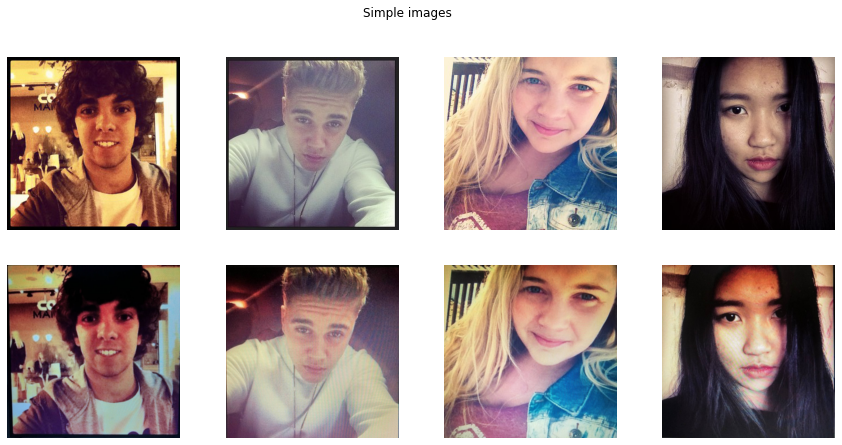

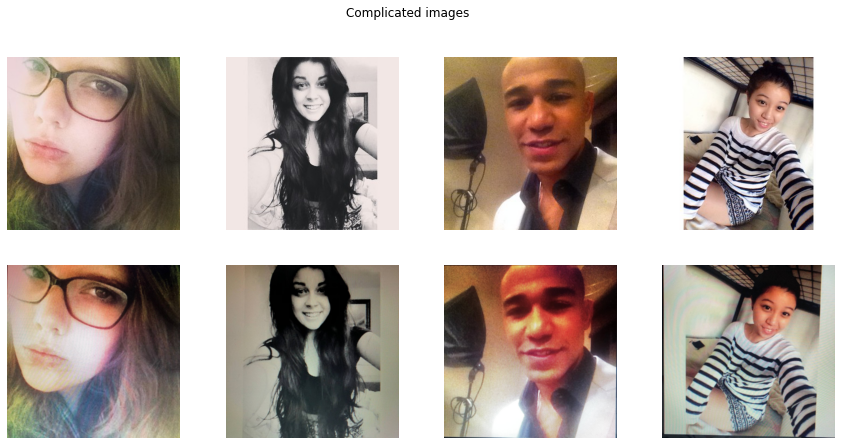

In [61]:
ind_max = F[:,0].argsort()[::-1][:4]
ind_min = F[:,0].argsort()[:4]

fig, axs = plt.subplots(2, 4, sharex=True, sharey=True, figsize=((15, 7)))
fig.suptitle('Simple images')

for i, ind in enumerate(ind_max):

    im_path = 'datasets/100_selfies/' + "{0:0=5d}".format(ind) + '.jpg'
    im = Image.open(im_path)
    axs[0][i].imshow(im)
    axs[0][i].axis("off")
    

    im_path = 'datasets/100_selfies_re' + str(d) + '/' +  "{0:0=5d}".format(ind) + '.jpg'
    im = Image.open(im_path)
    im = im.resize((306, 306))
    axs[1][i].imshow(im)
    axs[1][i].axis("off")


fig, axs = plt.subplots(2, 4, sharex=True, sharey=True, figsize=((15, 7)))
fig.suptitle('Complicated images')

for i, ind in enumerate(ind_min):

    im_path = 'datasets/100_selfies/' + "{0:0=5d}".format(ind) + '.jpg'
    im = Image.open(im_path)
    axs[0][i].imshow(im)
    axs[0][i].axis("off")
    

    im_path = 'datasets/100_selfies_re' + str(d) + '/' +  "{0:0=5d}".format(ind) + '.jpg'
    im = Image.open(im_path)
    im = im.resize((306, 306))
    axs[1][i].imshow(im)
    axs[1][i].axis("off")